# **Math-485: Topics in Data Science**

## **Textual Data Unit Project**

### Josh Winnes
---
## **Objective**

To produce an experimental evaluation of classifier performance on UN SDG labeled textual data. The evaluation should be conducted on a set of algorithms in combination with a set of NLP preprocessing steps, and conclude with the best performing algorithm with the associated preprocessing steps.

## **Specifications**

* prepare data as having been done in class and homework  
* write a function that will   
  * takes in a corpus (such as prepared so far) as input, and  
  * takes another parameter of “classifier\_algorithm” for the algorithm to use, the parameter settings for the algorithm should be part of the “classifier\_algorithm” parameter  
  * run the classifier with train\_test split, i.e., train on the training set and test on the test set  
  * report the metrics of precision, recall, f1\_score, and accuracy  
* run various classification algorithms on the UN SDG labeled data we have been using in class  
  * multinomial naive bayes   
  * multilayer perceptron (sklearn.neural\_network.MLPClassifier, note to use min\_df to ensure computation can be completed in reasonable time)  
  * ridge regression (sklearn.linear\_model.Ridge)  
  * combine with different preprocessing settings  
    * use count vectors vs. tfidf vectors  
    * use unigram only, bigram only, or both  
* evaluate all performance results in one table, with all configurations, bold face the numbers that give the best performance

for example, for one configuration, e.g., bigram with min\_df \= 3, the portion of table should contain

|  | MultinomialNB | MLP | Ridge |
| :---- | :---- | :---- | :---- |
| precision |  |  |  |
| recall |  |  |  |
| f1 |  |  |  |
| accuracy |  |  |  |

* for each SDG, what are the most differentiating features according to the classifier?  
* are there any overlaps between the SDG vocabularies?

## **Deliverables**

* A self contained python jupyter notebook that implements the specifications.  
* take the main text content from these pages, and feed them into your classifier and see how your model classifies them. Are the classifications reasonable? find a case where your classification is not reasonable and explain what the model does that leads to the not ideal classification.  
  [http://gianttortoise.org/en/beyond-tracking](http://gianttortoise.org/en/beyond-tracking)  
  [https://www.dhs.gov/blue-campaign/what-human-trafficking](https://www.dhs.gov/blue-campaign/what-human-trafficking)  
  [https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers](https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers)  
  [https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/](https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/)

## **Important note (to help reduce computation time if that is an issue)**

* when the classification takes too long to run on your computer (most likely they will on this project), set min\_df in the vectorizer to reduce the vocabulary size, which will reduce the matrix size drastically.   
* if you choose to run experiments on fewer number of SDGs, please be sure to include SDG 8 in your collection, and choose several others among  \[2,3,4,8,9,10,14,15,16\], to show your work on multiple classes

---

### **Scraping the Websites using Beautiful Soup 4**
This is necessary in order to get the text data into a dataframe so we can actually process the text in the website using our sklearn models later

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# List of URLs to scrape
urls = [
    "http://gianttortoise.org/en/beyond-tracking",
    "https://www.dhs.gov/blue-campaign/what-human-trafficking",
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers",
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/"
]

# Dictionary that links URLs to HTML Class names to locate the main text
class_name_dict = {
    "http://gianttortoise.org/en/beyond-tracking":'elementor-container elementor-column-gap-default',
    "https://www.dhs.gov/blue-campaign/what-human-trafficking":'field field--name-body field--type-text-with-summary field--label-hidden field__item',
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers":'field field--name-field-p-text field--type-text-long field--label-hidden clearfix',
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/":'post'
}

# Function to extract the main text from a webpage
def extract_main_text(url, class_name):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")

    # Extract main text        
    divs = soup.find_all('div', class_ = class_name)
    text = ''
    for div in divs:
        p_elements = div.find_all('p')
        li_elements = div.find_all('li')
        for p in p_elements:
            text += p.get_text() + " "
        for li in li_elements:
            text += li.get_text() + ' '

    return text

data = {"url": [], "text": []}

for url in urls:
    text = extract_main_text(url, class_name_dict.get(url))
    data["url"].append(url)
    data["text"].append(text)

# Create a DataFrame
df = pd.DataFrame(data)

df.head()

,url,text
0,http://gianttortoise.org/en/beyond-tracking,Having discovered some of the mechanisms gover...
1,https://www.dhs.gov/blue-campaign/what-human-t...,"Human trafficking involves the use of force, f..."
2,https://www.dol.gov/agencies/odep/program-area...,"Today, a confluence of factors is prompting Am..."
3,https://michigantoday.umich.edu/2022/08/26/pos...,"Scientist/author Becca Levy, BA ’87, is a prof..."


### **Importing the training data**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

In [3]:
data_dir = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True,drop=True)

In [4]:
corpus = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(corpus)
count_vector = count_vectorizer.transform(corpus).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
term_freq.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,8492
women,women,6017
development,development,5889
public,public,4819
social,social,4754
...,...,...
intimacy,intimacy,1
poioiat,poioiat,1
area1718,area1718,1
areal,areal,1


In [5]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_count_vector = count_vectorizer.transform(X_train) 
X_test_count_vector = count_vectorizer.transform(X_test) 

In [40]:
corpus = text_df.text
tfid_vectorizer = TfidfVectorizer(stop_words='english')
tfid_vectorizer.fit(corpus)
tfid_vector = tfid_vectorizer.transform(corpus).toarray() 
tfid_vector_df = pd.DataFrame(tfid_vector, columns=tfid_vectorizer.get_feature_names_out())
term_freq_tfid = pd.DataFrame({"term": tfid_vector_df.columns.values, "freq" : tfid_vector_df.sum(axis=0)})
term_freq_tfid.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,463.285714
women,women,417.526924
water,water,357.617993
development,development,354.615166
health,health,336.891578
...,...,...
abidance,abidance,0.082056
gabriel,gabriel,0.082056
emanuele,emanuele,0.082056
timeslot,timeslot,0.067790


In [41]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_tfid_vector = tfid_vectorizer.transform(X_train) 
X_test_tfid_vector = tfid_vectorizer.transform(X_test) 

### **Training the Models**

### Multinomial Naive Bayes

#### *Count Vector*

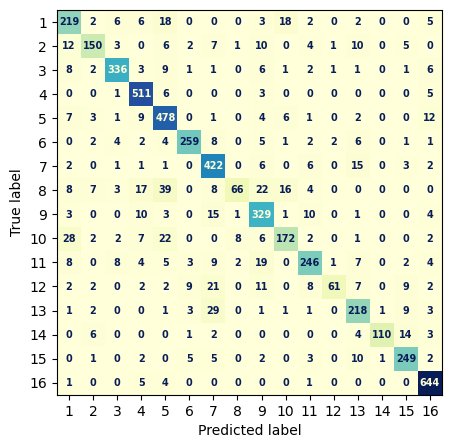

In [6]:
count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred_mnb = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [7]:
print(metrics.classification_report(y_test,y_pred_mnb, digits = 4))

              precision    recall  f1-score   support

           1     0.7324    0.7794    0.7552       281
           2     0.8380    0.7109    0.7692       211
           3     0.9205    0.8889    0.9044       378
           4     0.8826    0.9715    0.9249       526
           5     0.7993    0.9122    0.8520       524
           6     0.9152    0.8721    0.8931       297
           7     0.7992    0.9194    0.8551       459
           8     0.8462    0.3474    0.4925       190
           9     0.7705    0.8727    0.8184       377
          10     0.7963    0.6825    0.7350       252
          11     0.8425    0.7736    0.8066       318
          12     0.9242    0.4485    0.6040       136
          13     0.7676    0.8074    0.7870       270
          14     0.9821    0.7857    0.8730       140
          15     0.8498    0.8893    0.8691       280
          16     0.9266    0.9832    0.9541       655

    accuracy                         0.8444      5294
   macro avg     0.8496   

In [12]:
print('F1: ', metrics.f1_score(y_test, y_pred_mnb, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mnb))
print('Precision: ', metrics.precision_score(y_test, y_pred_mnb, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mnb, average='weighted'))

F1:  0.8379417993576547
Accuracy:  0.8443520967132603
Precision:  0.8476560661346947
Recall:  0.8443520967132603


#### *TFID Vector*

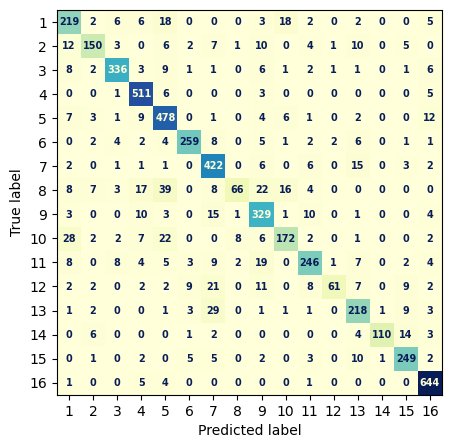

In [42]:
tfid_multinomialNB_clf = MultinomialNB().fit(X_train_tfid_vector, y_train)
y_pred_mnb_tfid = tfid_multinomialNB_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mnb_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [43]:
print(metrics.classification_report(y_test,y_pred_mnb_tfid, digits = 4))

              precision    recall  f1-score   support

           1     0.8520    0.5943    0.7002       281
           2     0.9565    0.3128    0.4714       211
           3     0.9296    0.8386    0.8818       378
           4     0.7266    0.9753    0.8328       526
           5     0.4602    0.9389    0.6177       524
           6     0.9307    0.7239    0.8144       297
           7     0.5819    0.9521    0.7223       459
           8     1.0000    0.0105    0.0208       190
           9     0.7869    0.7639    0.7752       377
          10     0.9118    0.2460    0.3875       252
          11     0.9408    0.5000    0.6530       318
          12     0.9000    0.0662    0.1233       136
          13     0.9056    0.6037    0.7244       270
          14     1.0000    0.3500    0.5185       140
          15     0.8391    0.7821    0.8096       280
          16     0.7821    0.9863    0.8724       655

    accuracy                         0.7185      5294
   macro avg     0.8440   

In [44]:
print('F1: ', metrics.f1_score(y_test, y_pred_mnb_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mnb_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_mnb_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mnb_tfid, average='weighted'))

F1:  0.6893211917058863
Accuracy:  0.7185493010955799
Precision:  0.7988754206452393
Recall:  0.7185493010955799


### Multilayer Perceptron

#### *Count Vector*

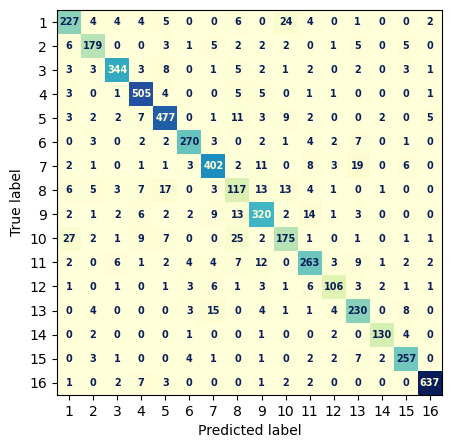

In [13]:
count_MLP_clf = MLPClassifier().fit(X_train_count_vector, y_train)
y_pred_mlp = count_MLP_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [14]:
print(metrics.classification_report(y_test,y_pred_mlp, digits = 4))

              precision    recall  f1-score   support

           1     0.8021    0.8078    0.8050       281
           2     0.8565    0.8483    0.8524       211
           3     0.9373    0.9101    0.9235       378
           4     0.9149    0.9601    0.9369       526
           5     0.8966    0.9103    0.9034       524
           6     0.9278    0.9091    0.9184       297
           7     0.8933    0.8758    0.8845       459
           8     0.6031    0.6158    0.6094       190
           9     0.8377    0.8488    0.8432       377
          10     0.7576    0.6944    0.7246       252
          11     0.8376    0.8270    0.8323       318
          12     0.8413    0.7794    0.8092       136
          13     0.8014    0.8519    0.8259       270
          14     0.9420    0.9286    0.9353       140
          15     0.8924    0.9179    0.9049       280
          16     0.9800    0.9725    0.9762       655

    accuracy                         0.8763      5294
   macro avg     0.8576   

In [15]:
print('F1: ', metrics.f1_score(y_test, y_pred_mlp, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mlp))
print('Precision: ', metrics.precision_score(y_test, y_pred_mlp, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mlp, average='weighted'))

F1:  0.8760477855986536
Accuracy:  0.876275028333963
Precision:  0.8763052289121723
Recall:  0.876275028333963


#### *TFID Vector*

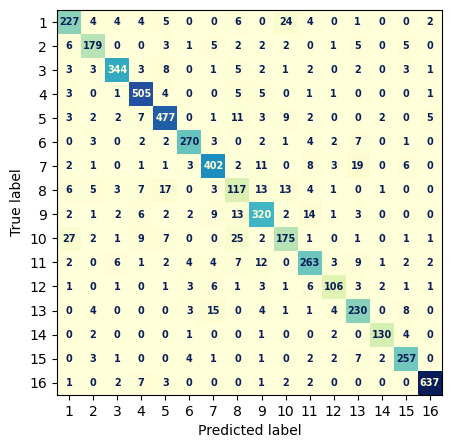

In [45]:
tfid_MLP_clf = MLPClassifier().fit(X_train_tfid_vector, y_train)
y_pred_mlp_tfid = tfid_MLP_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [46]:
print(metrics.classification_report(y_test,y_pred_mlp_tfid, digits = 4))

              precision    recall  f1-score   support

           1     0.8156    0.8185    0.8171       281
           2     0.8689    0.8483    0.8585       211
           3     0.9375    0.9127    0.9249       378
           4     0.9107    0.9696    0.9392       526
           5     0.9041    0.9179    0.9110       524
           6     0.9320    0.9226    0.9272       297
           7     0.8976    0.8780    0.8877       459
           8     0.6198    0.6263    0.6230       190
           9     0.8424    0.8647    0.8534       377
          10     0.7768    0.6905    0.7311       252
          11     0.8581    0.8365    0.8471       318
          12     0.8640    0.7941    0.8276       136
          13     0.8352    0.8444    0.8398       270
          14     0.9424    0.9357    0.9391       140
          15     0.9003    0.9357    0.9177       280
          16     0.9698    0.9802    0.9749       655

    accuracy                         0.8836      5294
   macro avg     0.8672   

In [47]:
print('F1: ', metrics.f1_score(y_test, y_pred_mlp_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_mlp_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_mlp_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_mlp_tfid, average='weighted'))

F1:  0.8830027580537596
Accuracy:  0.8836418587079713
Precision:  0.8830143408452087
Recall:  0.8836418587079713


### Ridge Classifier

#### *Count Vector*

In [16]:
from sklearn.linear_model import RidgeClassifierCV

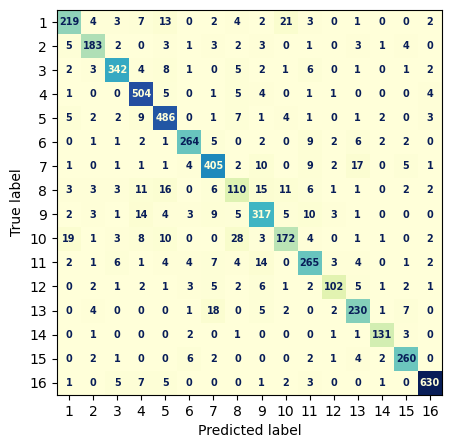

In [17]:
count_ridge_clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='accuracy').fit(X_train_count_vector, y_train)
y_pred_ridge = count_ridge_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [18]:
print(metrics.classification_report(y_test,y_pred_ridge, digits = 4))

              precision    recall  f1-score   support

           1     0.8423    0.7794    0.8096       281
           2     0.8714    0.8673    0.8694       211
           3     0.9218    0.9048    0.9132       378
           4     0.8842    0.9582    0.9197       526
           5     0.8725    0.9275    0.8992       524
           6     0.9135    0.8889    0.9010       297
           7     0.8728    0.8824    0.8776       459
           8     0.6286    0.5789    0.6027       190
           9     0.8234    0.8408    0.8320       377
          10     0.7854    0.6825    0.7304       252
          11     0.8230    0.8333    0.8281       318
          12     0.8644    0.7500    0.8031       136
          13     0.8333    0.8519    0.8425       270
          14     0.9225    0.9357    0.9291       140
          15     0.9059    0.9286    0.9171       280
          16     0.9707    0.9618    0.9663       655

    accuracy                         0.8727      5294
   macro avg     0.8585   

In [19]:
print('F1: ', metrics.f1_score(y_test, y_pred_ridge, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_ridge))
print('Precision: ', metrics.precision_score(y_test, y_pred_ridge, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_ridge, average='weighted'))

F1:  0.8714620420008727
Accuracy:  0.8726860596902153
Precision:  0.8715380108073195
Recall:  0.8726860596902153


#### *TFID Vector*

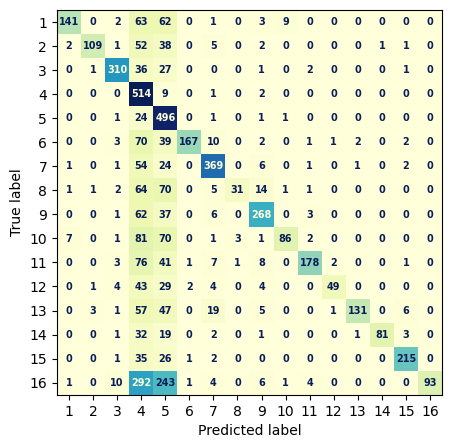

In [48]:
tfid_ridge_clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='accuracy').fit(X_train_tfid_vector, y_train)
y_pred_ridge_tfid = count_ridge_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [49]:
print(metrics.classification_report(y_test,y_pred_ridge_tfid, digits = 4))

              precision    recall  f1-score   support

           1     0.9216    0.5018    0.6498       281
           2     0.9478    0.5166    0.6687       211
           3     0.9064    0.8201    0.8611       378
           4     0.3305    0.9772    0.4940       526
           5     0.3884    0.9466    0.5508       524
           6     0.9709    0.5623    0.7122       297
           7     0.8444    0.8039    0.8237       459
           8     0.8857    0.1632    0.2756       190
           9     0.8272    0.7109    0.7646       377
          10     0.8776    0.3413    0.4914       252
          11     0.9271    0.5597    0.6980       318
          12     0.9245    0.3603    0.5185       136
          13     0.9704    0.4852    0.6469       270
          14     0.9878    0.5786    0.7297       140
          15     0.9307    0.7679    0.8415       280
          16     1.0000    0.1420    0.2487       655

    accuracy                         0.6116      5294
   macro avg     0.8526   

In [50]:
print('F1: ', metrics.f1_score(y_test, y_pred_ridge_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_ridge_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_ridge_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_ridge_tfid, average='weighted'))

F1:  0.6081390705182382
Accuracy:  0.6116358141292029
Precision:  0.8108493230957765
Recall:  0.6116358141292029


### Random Forest

#### *Count Vector*

In [20]:
from sklearn.ensemble import RandomForestClassifier

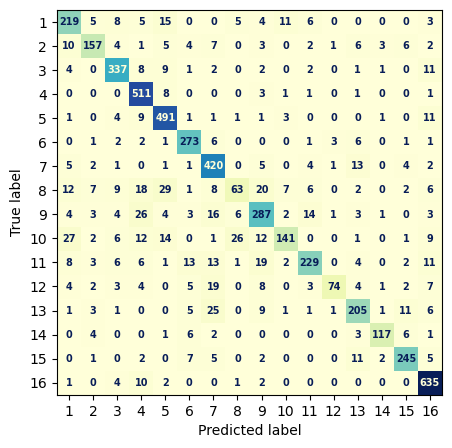

In [21]:
count_rf_clf = RandomForestClassifier(max_depth=100).fit(X_train_count_vector, y_train)
y_pred_rf = count_rf_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [22]:
print(metrics.classification_report(y_test, y_pred_rf, digits=4))

              precision    recall  f1-score   support

           1     0.7399    0.7794    0.7591       281
           2     0.8263    0.7441    0.7830       211
           3     0.8663    0.8915    0.8787       378
           4     0.8322    0.9715    0.8965       526
           5     0.8451    0.9370    0.8887       524
           6     0.8531    0.9192    0.8849       297
           7     0.8000    0.9150    0.8537       459
           8     0.6117    0.3316    0.4300       190
           9     0.7613    0.7613    0.7613       377
          10     0.8393    0.5595    0.6714       252
          11     0.8513    0.7201    0.7802       318
          12     0.9136    0.5441    0.6820       136
          13     0.7885    0.7593    0.7736       270
          14     0.9213    0.8357    0.8764       140
          15     0.8750    0.8750    0.8750       280
          16     0.8894    0.9695    0.9277       655

    accuracy                         0.8319      5294
   macro avg     0.8259   

In [23]:
print('F1: ', metrics.f1_score(y_test, y_pred_rf, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_rf))
print('Precision: ', metrics.precision_score(y_test, y_pred_rf, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_rf, average='weighted'))

F1:  0.8246223895713095
Accuracy:  0.8318851530034
Precision:  0.8292327738459466
Recall:  0.8318851530034


#### *TFID Vector*

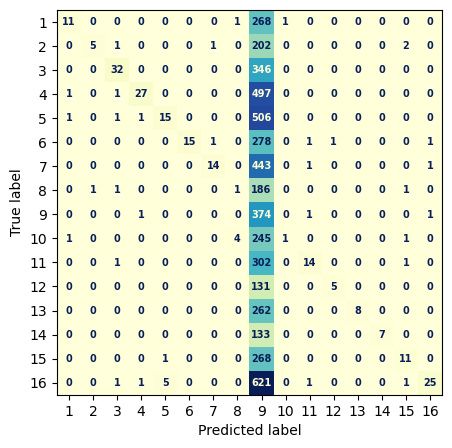

In [51]:
tfid_rf_clf = RandomForestClassifier(max_depth=100).fit(X_train_tfid_vector, y_train)
y_pred_rf_tfid = count_rf_clf.predict(X_test_tfid_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tfid, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [52]:
print(metrics.classification_report(y_test, y_pred_rf_tfid, digits=4))

              precision    recall  f1-score   support

           1     0.7857    0.0391    0.0746       281
           2     0.8333    0.0237    0.0461       211
           3     0.8421    0.0847    0.1538       378
           4     0.9000    0.0513    0.0971       526
           5     0.7143    0.0286    0.0550       524
           6     1.0000    0.0505    0.0962       297
           7     0.8750    0.0305    0.0589       459
           8     0.1667    0.0053    0.0102       190
           9     0.0739    0.9920    0.1375       377
          10     0.5000    0.0040    0.0079       252
          11     0.7778    0.0440    0.0833       318
          12     0.8333    0.0368    0.0704       136
          13     1.0000    0.0296    0.0576       270
          14     1.0000    0.0500    0.0952       140
          15     0.6471    0.0393    0.0741       280
          16     0.8929    0.0382    0.0732       655

    accuracy                         0.1067      5294
   macro avg     0.7401   

In [53]:
print('F1: ', metrics.f1_score(y_test, y_pred_rf_tfid, average='weighted'))
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_rf_tfid))
print('Precision: ', metrics.precision_score(y_test, y_pred_rf_tfid, average='weighted'))
print('Recall: ', metrics.recall_score(y_test, y_pred_rf_tfid, average='weighted'))

F1:  0.07816198861299144
Accuracy:  0.106724593879864
Precision:  0.7524425749328368
Recall:  0.106724593879864


### **Results**


#### *Count Vectorizer Classification*
|  | Multinomial NB | Multilayer Perceptron | Ridge | Random Forest |
| :---- | :---- | :---- | :---- | :---- |
| F1 | 0.838 | **0.876** | 0.871 | 0.825 |
| Accuracy | 0.844 | **0.876** | 0.873 | 0.832 |
| Precision | 0.848 | **0.876** | 0.872 | 0.829 |
| Recall | 0.844 | **0.876** | 0.873 | 0.832 |
#### *TF-IDF Vectorizer Classification*
|  | Multinomial NB | Multilayer Perceptron | Ridge | Random Forest |
| :---- | :---- | :---- | :---- | :---- |
| F1 | 0.689 | **0.883** | 0.608 | 0.078 |
| Accuracy | 0.719 | **0.884** | 0.612 | 0.107 |
| Precision | 0.799 | **0.883** | 0.811 | 0.752 |
| Recall | 0.719 | **0.883** | 0.612 | 0.107 |


In both cases, the Multilayer Perceptron classifier had the best score. The TF-IDF Vectorized Multilayer Perceptron Classifier had the highest accuracy score with 0.884, so I will use that model to classify the websites.

### **Classifying the Websites**

The Multilayer Perceptron Neural Network Classifier had the best accuracy score (0.87) so I will use it to classify the webpages.

In [54]:
COUNT_CLASSIFIER = tfid_MLP_clf

text_to_predict = df.text
text_to_predict_transformed = count_vectorizer.transform(text_to_predict)

print('Count MLP Classifier Predicitions: ', COUNT_CLASSIFIER.predict(text_to_predict_transformed))


Count MLP Classifier Predicitions:  [15  5  4  3]


#### *Results Table*

| URL | SDG |
| ----- | ----- |
| https://gianttortoise.org/en/beyond-tracking | 15 \- Life on Land |
| https://www.dhs.gov/blue-campaign/what-human-trafficking | 5 \- Gender Equality |
| https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers | 4 \- Quality Education |
| https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/ | 3 \- Good Health and Well Being |